In [1]:
# Import all required libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

All libraries imported successfully!
TensorFlow version: 2.20.0


In [2]:
# Load the MATLAB v7.3 file using h5py
mat_file = h5py.File('data/data_s1_64.mat', 'r')

# Extract the main data array
data_key = list(mat_file.keys())[0]
eeg_data = np.array(mat_file[data_key])

print(f"Data key: {data_key}")
print(f"Data shape: {eeg_data.shape}")
print(f"\nActual structure (from paper):")
print(f"  Dimension 0 (12): Conditions")
print(f"  Dimension 1 (60): Frequencies (1-60 Hz)")
print(f"  Dimension 2 (5140): Timepoints (5.14s at 1000 Hz)")
print(f"  Dimension 3 (64): Channels")
print(f"  Dimension 4 (2): Modulation Depths (0=Low, 1=High)")

KeyboardInterrupt: 

In [ ]:
# Load channel information with correct encoding
channel_info = pd.read_csv('data/Electrode_channels_information.csv', encoding='utf-8')
print("Channel information loaded!")
print(f"\nFirst 10 channels:")
print(channel_info[['labels', 'index']])

Channel information loaded!

First 10 channels:
   labels  index
0   'FP1'      1
1   'FPz'      2
2   'FP2'      3
3   'AF3'      4
4   'AF4'      5
..    ...    ...
59  'CB1'     60
60   'O1'     61
61   'Oz'     62
62   'O2'     63
63  'CB2'     64

[64 rows x 2 columns]


In [ ]:
# Find correct channel indices for O1, O2, P3, P4
target_channels = ['O1', 'O2', 'P3', 'P4']
channel_indices = []

for ch_name in target_channels:
    # Remove quotes from labels column
    idx = channel_info[channel_info['labels'].str.strip("'") == ch_name].index
    if len(idx) > 0:
        channel_indices.append(idx[0])
        print(f"{ch_name}: index {idx[0]}")
    else:
        print(f"Warning: {ch_name} not found")

print(f"\nChannel indices for {target_channels}: {channel_indices}")

In [ ]:
#Defining indicies for easy access
my_channels = [60, 62, 45, 49]

freq_8hz_idx = 7
freq_14hz_idx = 13

high_depth_idx = 1

In [ ]:
#Isolate high depth data
data_high_depth = eeg_data[:, :, :, :, high_depth_idx]

In [ ]:
#Separate frequencies from isolated high depth data
raw_8hz = data_high_depth[:, freq_8hz_idx, :, :]
raw_14hz = data_high_depth[:, freq_14hz_idx, :, :]

In [ ]:
#Extract only the desired channels
final_8hz = raw_8hz[:, :, my_channels]
final_14hz = raw_14hz[:, :, my_channels]

In [ ]:
import numpy as np
from scipy.signal import welch

# --- CONFIGURATION ---
# Define the 8Hz and 14Hz indices (from your previous steps)
target_freqs = {
    8: 7,   # Label 0
    14: 13  # Label 1
}

# Your Channels (Indices for O1, O2, P3, P4)
my_channels = [60, 62, 45, 49]
high_depth_idx = 1

# WINDOWING PARAMETERS
fs = 125                # Target sampling rate (changed to 125Hz)
window_size = 1 * fs    # 1 second window (125 samples)
step_size = int(0.25 * fs)   # 0.25s step (75% overlap) -> MORE DATA!

X = []
y = []

print("--- Starting Data Processing ---")

for hz_label, freq_idx in target_freqs.items():
    # 1. SLICE & FIX SHAPE
    # Slice: [All Trials, Specific Freq, All Time, Specific Channels, High Depth]
    # Result: (12, 60, 5140, 4, 2) -> (12, 5140, 4)
    # Note: We verify shape manually to handle the "NumPy swap"
    subset_raw = eeg_data[:, freq_idx, :, my_channels, high_depth_idx]
    
    # Fix the shape if it's (4, 12, 5140) -> make it (12, 5140, 4)
    if subset_raw.shape == (4, 12, 5140):
        subset_raw = subset_raw.transpose(1, 2, 0)
        
    # 2. DOWNSAMPLE (1000Hz -> 125Hz)
    # Take every 8th sample [::8]
    # New shape: (12, 642, 4)
    subset_125hz = subset_raw[:, ::8, :]
    
    print(f"Processing {hz_label}Hz | Shape: {subset_125hz.shape}")

    # 3. WINDOWING LOOP
    # Loop through each of the 12 trials
    for trial_idx in range(subset_125hz.shape[0]):
        trial_data = subset_125hz[trial_idx] # Shape (642, 4)
        
        # Slide the window across the trial
        # Stop when the window would go past the end
        for start_sample in range(0, trial_data.shape[0] - window_size, step_size):
            end_sample = start_sample + window_size
            
            # Extract 1-second window
            # Shape: (125, 4)
            window = trial_data[start_sample:end_sample, :]
            
            # 4. FEATURE EXTRACTION (PSD)
            # Convert Time (Waves) -> Frequency (Power)
            f, psd = welch(window, fs=fs, nperseg=window_size, axis=0)
            
            # Focus on 3Hz - 30Hz (The "Brain Band")
            freq_mask = (f >= 3) & (f <= 30)
            psd_focused = psd[freq_mask, :]
            
            # Average the 4 channels into 1 strong signal
            # Shape: (Freq_Bins,)
            psd_mean = np.mean(psd_focused, axis=1)
            
            # 5. SAVE
            X.append(psd_mean)
            y.append(0 if hz_label == 8 else 1)

# Convert to Arrays for TensorFlow
X = np.array(X)
y = np.array(y)

print("\n--- PROCESSING COMPLETE ---")
print(f"Final Training Data Shape (X): {X.shape}")
print(f"Final Labels Shape (y):        {y.shape}")

Original Shape: (408, 28)
PCA Shape:      (408, 2)
Explained Variance: [0.17301975 0.08309855]


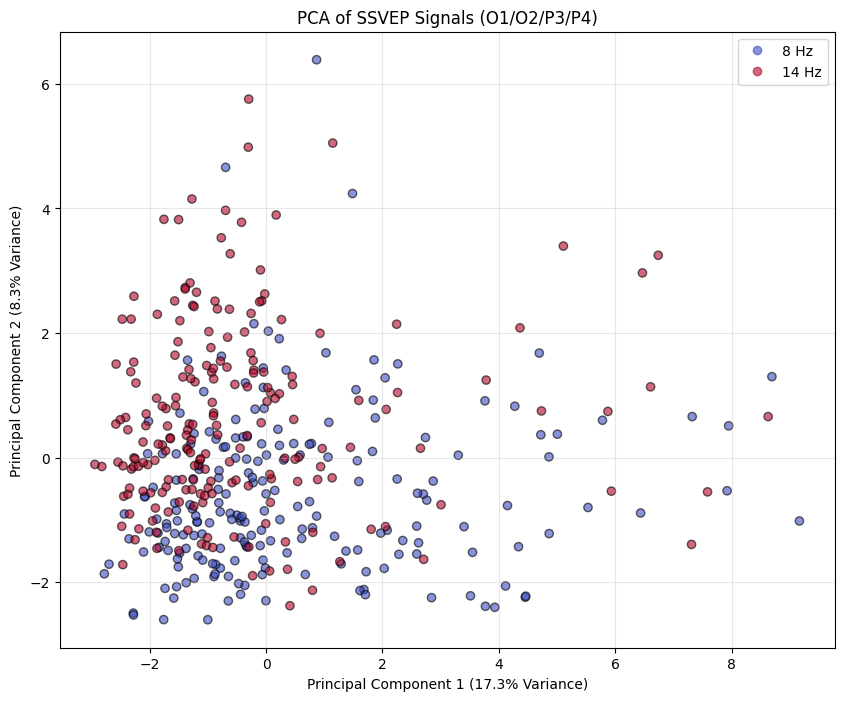

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Standardize the Data
# PCA works best when data is centered (Mean=0, Variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Apply PCA (Reduce 28 dimensions -> 2 dimensions)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(f"Original Shape: {X.shape}")
print(f"PCA Shape:      {X_pca.shape}")
print(f"Explained Variance: {pca.explained_variance_ratio_}") 
# This tells us how much information was preserved (e.g., [0.45, 0.22] means 67% of signal kept)

# 3. Plot the Results
plt.figure(figsize=(10, 8))

# Scatter plot: X_pca[:, 0] is the x-axis, X_pca[:, 1] is the y-axis
# c=y colors the dots based on label (0=8Hz, 1=14Hz)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k')

# Add legend and labels
classes = ['8 Hz', '14 Hz']
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.title('PCA of SSVEP Signals (O1/O2/P3/P4)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%} Variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%} Variance)')
plt.grid(True, alpha=0.3)

plt.show()

Training Shape: (326, 28, 1)
Testing Shape:  (82, 28, 1)

--- STARTING TRAINING ---
Epoch 1/40


/Users/ashmith/neuroquest/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5184 - loss: 0.7076 - val_accuracy: 0.6463 - val_loss: 0.6439
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6564 - loss: 0.6348 - val_accuracy: 0.7073 - val_loss: 0.6033
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7393 - loss: 0.5810 - val_accuracy: 0.7073 - val_loss: 0.5609
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7393 - loss: 0.5581 - val_accuracy: 0.7317 - val_loss: 0.5284
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7853 - loss: 0.5163 - val_accuracy: 0.7317 - val_loss: 0.4975
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7791 - loss: 0.4862 - val_accuracy: 0.7317 - val_loss: 0.4755
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7945 - loss: 0.4570 - val_accuracy: 0.7317 - val_loss: 0.4608
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8129 - loss: 0.4214 - val_accuracy: 0.7683 - val_loss: 0.4403
Epo

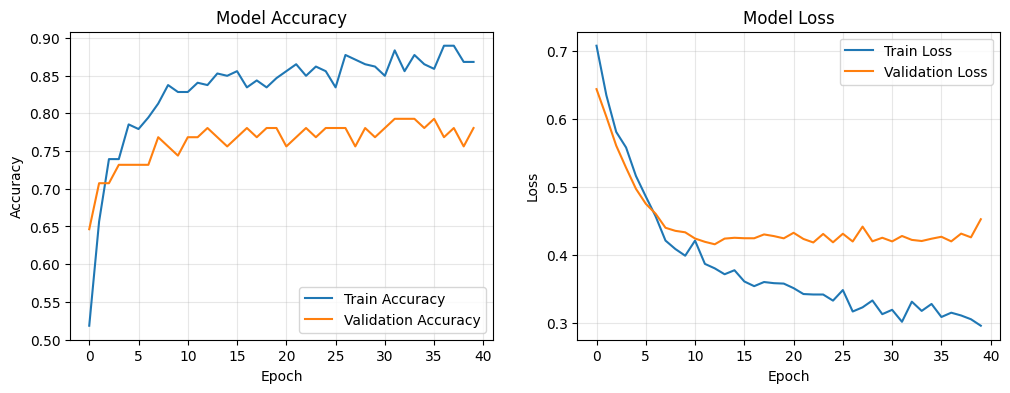


Model saved as 'neuroquest_model_s1.h5'


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. PREPARE DATA
# Reshape X to add the "channel" dimension for the CNN
# Current shape: (408, 28) -> New shape: (408, 28, 1)
X_cnn = X[..., np.newaxis]

# Split into Training (80%) and Testing (20%)
# Stratify=y ensures we get an equal mix of 8Hz and 14Hz in both sets
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape:  {X_test.shape}")

# 2. BUILD THE BRAIN (1D CNN)
model = tf.keras.Sequential([
    # Layer 1: Convolution
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    
    # --- NEW: Dropout Layer ---
    # Randomly drops 20% of connections to prevent memorization
    tf.keras.layers.Dropout(0.2),

    # Layer 2: Flatten
    tf.keras.layers.Flatten(),
    
    # Layer 3: Dense
    tf.keras.layers.Dense(32, activation='relu'),
    
    # --- NEW: Dropout Layer ---
    # A stronger dropout before the final decision
    tf.keras.layers.Dropout(0.4),
    
    # Layer 4: Output
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile with a slightly lower learning rate for stability
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# 3. TRAIN
print("\n--- STARTING TRAINING ---")
history = model.fit(X_train, y_train, 
                    epochs=40, 
                    batch_size=16, 
                    validation_data=(X_test, y_test),
                    verbose=1)

# 4. VISUALIZE LEARNING
plt.figure(figsize=(12, 4))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

# 5. SAVE THE MODEL
model.save('neuroquest_model_s1.h5')
print("\nModel saved as 'neuroquest_model_s1.h5'")

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

X_cnn = X[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)

# --- 2. DEFINE THE MODEL-BUILDING FUNCTION ---
def build_model(hp):
    model = tf.keras.Sequential()
    
    # Tunable Parameter 1: Number of filters in the Conv Layer
    hp_filters = hp.Int('filters', min_value=8, max_value=64, step=8)
    
    # Tunable Parameter 2: Kernel size (Window of the scan)
    hp_kernel = hp.Choice('kernel_size', values=[3, 5, 7])
    
    model.add(tf.keras.layers.Conv1D(
        filters=hp_filters, 
        kernel_size=hp_kernel, 
        activation='relu', 
        input_shape=(X_train.shape[1], 1)
    ))
    
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Tunable Parameter 3: Dropout Rate
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(tf.keras.layers.Dropout(hp_dropout))
    
    model.add(tf.keras.layers.Flatten())
    
    # Tunable Parameter 4: Dense Layer Size
    hp_units = hp.Int('units', min_value=16, max_value=64, step=16)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    model.add(tf.keras.layers.Dropout(hp_dropout))
    
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    # Tunable Parameter 5: Learning Rate
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# --- 3. SETUP THE TUNER ---
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    directory='neuroquest_tuning',
    project_name='ssvep_optimization'
)

# Stop early if val_accuracy doesn't improve
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# --- 4. RUN THE SEARCH ---
print("\n--- STARTING HYPERPARAMETER TUNING ---")
tuner.search(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[stop_early])

# --- 5. GET THE BEST MODEL ---
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
Best Filters: {best_hps.get('filters')}
Best Kernel: {best_hps.get('kernel_size')}
Best Dropout: {best_hps.get('dropout')}
Best Units: {best_hps.get('units')}
Best LR: {best_hps.get('learning_rate')}
""")

Reloading Tuner from neuroquest_tuning/ssvep_optimization/tuner0.json

--- STARTING HYPERPARAMETER TUNING ---

The hyperparameter search is complete. 
Best Filters: 24
Best Kernel: 3
Best Dropout: 0.30000000000000004
Best Units: 16
Best LR: 0.001



/Users/ashmith/neuroquest/env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 22, 40)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 11, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 11, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 440)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │        21,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            98 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,586 (84.32 KB)

 Trainable params: 21,586 (84.32 KB)

 Non-trainable params: 0 (0.00 B)


--- TRAINING OPTIMIZED MODEL ---
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6442 - loss: 0.6604 - val_accuracy: 0.7561 - val_loss: 0.6083
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7515 - loss: 0.5534 - val_accuracy: 0.7683 - val_loss: 0.5117
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7975 - loss: 0.4487 - val_accuracy: 0.7805 - val_loss: 0.4458
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8466 - loss: 0.3981 - val_accuracy: 0.7561 - val_loss: 0.4446
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8252 - loss: 0.3708 - val_accuracy: 0.7683 - val_loss: 0.4266
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8528 - loss: 0.3510 - val_accuracy: 0.7683 - val_loss: 0.4138
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8558 - loss: 0.3217 - val_accuracy: 0.7561 - val_loss: 0.4016
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8589 - loss: 0.3369 

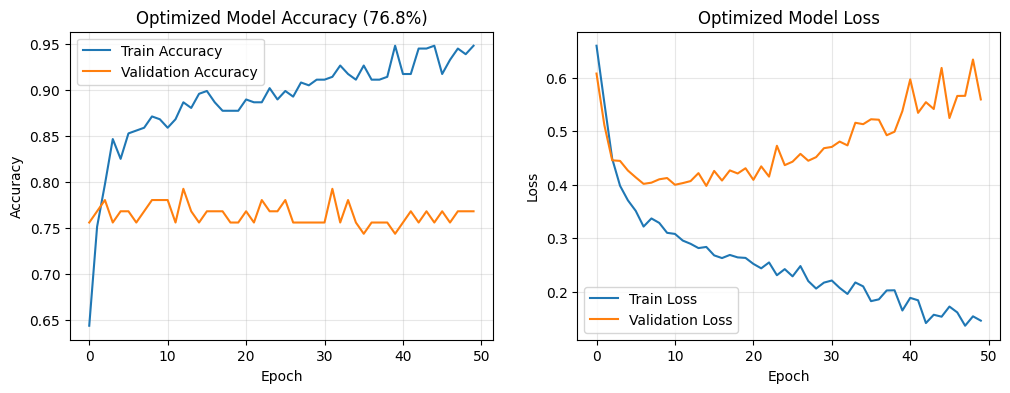

Champion model saved!


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# 1. PREPARE DATA (Same as before)
# Ensure X and y are loaded
X_cnn = X[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, stratify=y, random_state=42)

# 2. BUILD THE OPTIMIZED MODEL
model = tf.keras.Sequential([
    # Tuned: 40 Filters, Kernel Size 7
    tf.keras.layers.Conv1D(filters=40, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], 1)),
    
    tf.keras.layers.MaxPooling1D(pool_size=2),
    
    # Tuned: Dropout 0.2
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    
    # Tuned: 48 Units
    tf.keras.layers.Dense(48, activation='relu'),
    
    # Tuned: Dropout 0.2
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(2, activation='softmax')
])

# Tuned: Learning Rate 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 3. TRAIN THE CHAMPION
print("\n--- TRAINING OPTIMIZED MODEL ---")
history = model.fit(X_train, y_train, 
                    epochs=50,  # Increased epochs for final convergence
                    batch_size=16, 
                    validation_data=(X_test, y_test),
                    verbose=1)

# 4. EVALUATE
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nFinal Validation Accuracy: {val_acc*100:.2f}%")

# 5. PLOT RESULTS
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Optimized Model Accuracy ({val_acc*100:.1f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Optimized Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. SAVE
model.save('neuroquest_champion_s1.h5')
print("Champion model saved!")